# Iris Categorisation - TensorFlow

Based on the example [here](https://www.tensorflow.org/guide/premade_estimators)

In [2]:
train_path = 'data/iris_training.csv'  # http://download.tensorflow.org/data/iris_training.csv
test_path = 'data/iris_test.csv'       # http://download.tensorflow.org/data/iris_test.csv

In [3]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth',
                    'PetalLength', 'PetalWidth', 'Species']
SPECIES = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}

## Explore the data

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
!head -n5 {train_path}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


The first line of the csv gives a count of:
- the number of training examples (120) 
- the number of features for each (4) 
- a species list.

In [6]:
def iris_csv_to_df(csv_path):
    df = pd.read_csv(csv_path, names=CSV_COLUMN_NAMES, header=0)
    df['Species'] = df['Species'].map(SPECIES)
    return df

In [7]:
train_df, test_df = map(iris_csv_to_df, (train_path, test_path))

In [8]:
train_df.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,Virginica
1,5.0,2.3,3.3,1.0,Versicolor
2,4.9,2.5,4.5,1.7,Virginica
3,4.9,3.1,1.5,0.1,Setosa
4,5.7,3.8,1.7,0.3,Setosa


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


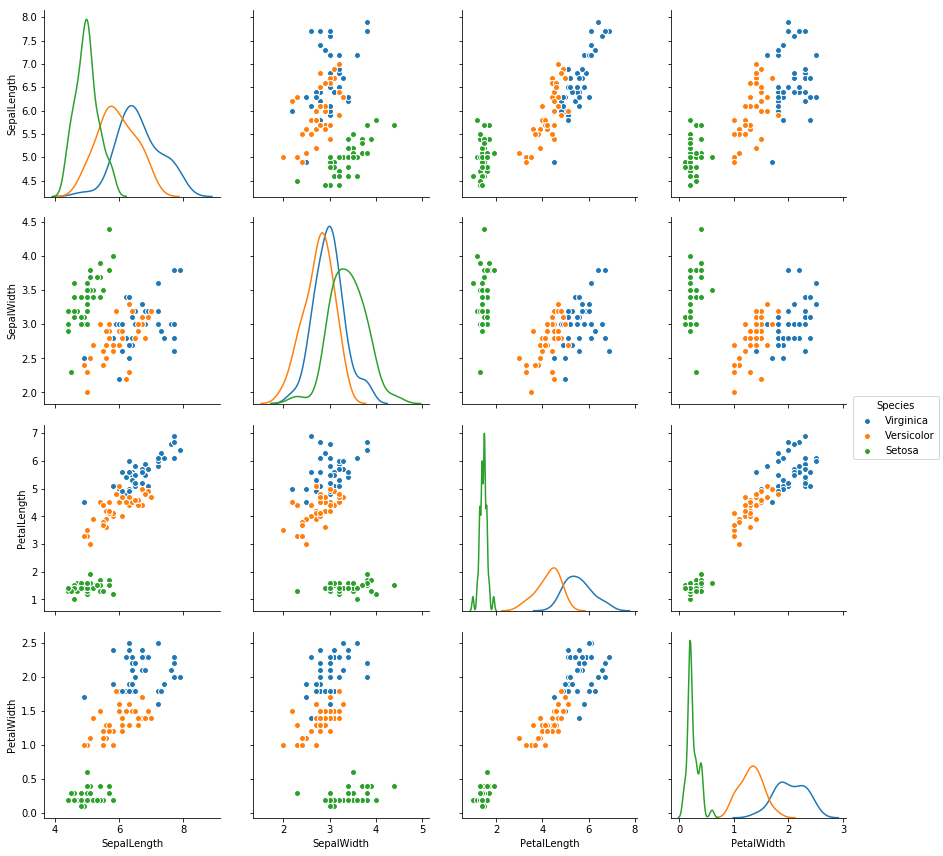

In [9]:
sns.pairplot(train_df, hue='Species', diag_kind='kde', size=3);

Clearly the *Setosa* species can be clearly identified based on its petal length alone.  Differentiating between the others may take a combination of features. 

## Learn a Model

In [10]:
import tensorflow as tf
tfi = tf.estimator.inputs

In [11]:
# return to raw data
train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)

train_x, train_y = train, train.pop('Species')
test_x, test_y = test, test.pop('Species')

In [12]:
BATCH_SIZE = 100
TRAIN_STEPS = 1000

In [13]:
# Feature columns describe how to use the input.
my_feature_columns = [
    tf.feature_column.numeric_column(key)
    for key in train_x.keys()
]

In [21]:
# Build 2 hidden layer DNN with 10, 10 units respectively.

# ! Must create a new classifier instance every time we train
# or successive training events will build on previous ones.
# Alternatively, set the model output dir manually and remove

classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    hidden_units=[10, 10], 
    n_classes=3,  # 3 species of iris to group by
)

# Train the Model.
classifier.train(
    input_fn=tfi.pandas_input_fn(
        train_x, train_y, BATCH_SIZE, 
        shuffle=True, num_epochs=500
    ),
    steps=TRAIN_STEPS,
);

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp6dcgiz9y', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb679648dd8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp6dcgiz9y/model.ckpt.
INFO:tensorflow:loss = 108.4

In [22]:
# Evaluate the model.
eval_result = classifier.evaluate(
    input_fn=tfi.pandas_input_fn(test_x, test_y, BATCH_SIZE, shuffle=False)
)

print('\nTest set accuracy: {accuracy:0.3f}'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-10-22:30:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6dcgiz9y/model.ckpt-600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-10-22:30:28
INFO:tensorflow:Saving dict for global step 600: accuracy = 0.96666664, average_loss = 0.057878915, global_step = 600, loss = 1.7363675

Test set accuracy: 0.967


## Generate Predictions
Run unseen data into the model.

In [23]:
valid = pd.read_hdf('data/validation_data.hdf', 'test1')

features = valid.drop('Species', axis=1)

In [24]:
# Use model to generate predictions
predictions = classifier.predict(
    input_fn=tfi.pandas_input_fn(features, shuffle=False)
)

template = ('\nPrediction is "{}" ({:.1f}%), \t expected "{}"')

for pred_dict, expec in zip(predictions, valid['Species']):
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]
    print(template.format(SPECIES[class_id], 100 * probability, expec))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6dcgiz9y/model.ckpt-600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Prediction is "Setosa" (99.5%), 	 expected "Setosa"

Prediction is "Versicolor" (99.0%), 	 expected "Versicolor"

Prediction is "Virginica" (94.3%), 	 expected "Virginica"


#### Examine the examples

These examples were provided by the documentation.  Lets take a look at how easy they made it for themselves by plotting the validation examples (with a red cross) over the top of their species attribute distributions.

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


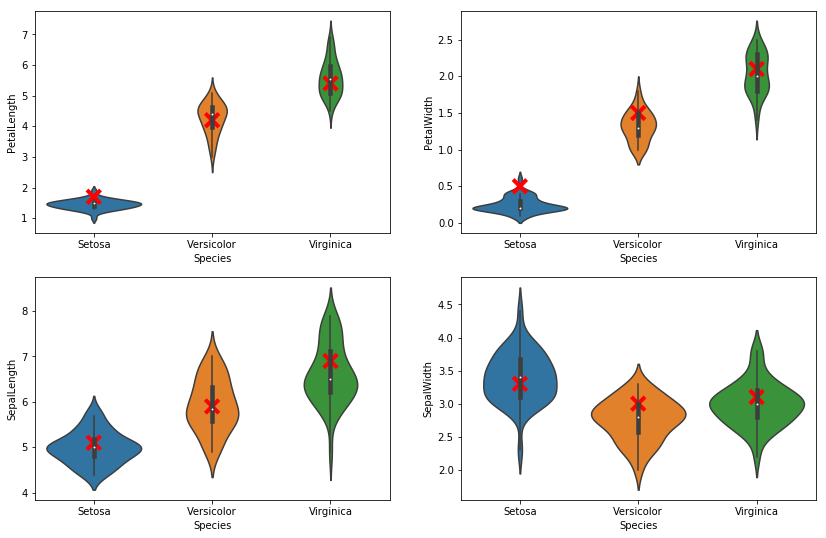

In [20]:
def compare_plot(column):
    ax = sns.violinplot('Species', column, data=train_df, order=SPECIES.values())
    sns.pointplot(x='Species', y=column, data=valid, ax=ax, color='red', markers='x', scale=2, join=False, order=SPECIES.values())
    
plt.figure(figsize=(14,9))
for i, feature in enumerate(features.columns):
    plt.subplot(2,2,i+1)
    compare_plot(feature)

The validation set provided by the demonstration are generally quite typical of their species.  Infact many of the measurements are almost the median for their types with *PetalWidth* for the *Setosa* example being the only datapoint outside of the inter-quartile range.